# Playlist Classifier

Given a list of playlists, can unknown tracks be correctly classified?

In [27]:
playlist_names = ["RAP", "EDM", "ROCK", "METAL", "JAZZ", "POP"] # super-genres
# playlist_names = ["DNB", "HOUSE", "TECHNO", "GARAGE", "DUBSTEP", "BASS"] # EDM playlists
# playlist_names = ["20s rap", "10s rap", "00s rap", "90s rap", "80s rap"] # rap decades
# playlist_names = ["UK RAP", "US RAP"] # UK/US split
# playlist_names = ["uk rap", "grime", "drill", "afro bash"] # british rap playlists
# playlist_names = ["20s rap", "10s rap", "00s rap", "90s rap", "80s rap", "trap", "gangsta rap", "industrial rap", "weird rap", "jazz rap", "boom bap", "trap metal"] # american rap playlists
# playlist_names = ["rock", "indie", "punk", "pop rock", "bluesy rock", "hard rock", "chilled rock", "emo", "pop punk", "stoner rock/metal", "post-hardcore", "melodic hardcore", "art rock", "post-rock", "classic pop punk", "90s rock & grunge", "90s indie & britpop", "psych"] # rock playlists
# playlist_names = ["metal", "metalcore", "mathcore", "hardcore", "black metal", "death metal", "doom metal", "sludge metal", "classic metal", "industrial", "nu metal", "calm metal", "thrash metal"] # metal playlists

# headers = float_headers + ["duration_ms", "mode", "loudness", "tempo"]
headers = float_headers

Pull and process playlist information.

1. Get live playlist track information from spotify
2. Filter listening history for these tracks

Filter out tracks without features and drop duplicates before taking only the descriptor parameters

In [28]:
playlists = [get_playlist(i, spotnet) for i in playlist_names] # 1)

# filter playlists by join with playlist track/artist names
filtered_playlists = [pd.merge(track_frame(i.tracks), scrobbles, on=['track', 'artist']) for i in playlists] # 2)

filtered_playlists = [i[pd.notnull(i["uri"])] for i in filtered_playlists]
# distinct on uri
filtered_playlists = [i.drop_duplicates(['uri']) for i in filtered_playlists]
# select only descriptor float columns
filtered_playlists = [i.loc[:, headers] for i in filtered_playlists]

Construct the dataset with associated labels before splitting into a train and test set.

In [29]:
dataset = pd.concat(filtered_playlists)
labels = [np.full(len(plst), idx) for idx, plst in enumerate(filtered_playlists)]
labels = np.concatenate(labels)

data_train, data_test, labels_train, labels_test = train_test_split(dataset, labels, test_size=0.33, random_state=70)

# SVM
Support Vector Machine

73.47% Accurate


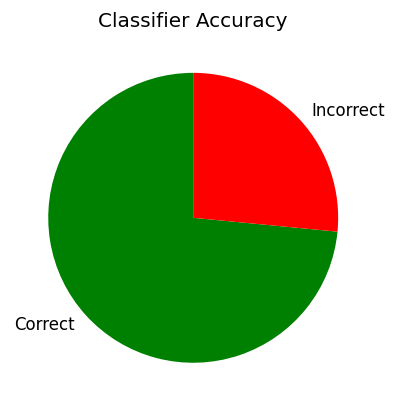

In [30]:
### TRAIN ###
clf = svm.SVC()
clf.fit(data_train, labels_train)

### TEST ###
pred_test_labels = clf.predict(data_test)

### EVALUATE ###
correct = [i == pred_test_labels[idx] for idx, i in enumerate(labels_test)]
correct = sum(correct) / len(correct)
print(f'{correct*100:.2f}% Accurate')

plt.pie([correct, 1 - correct], labels=["Correct", "Incorrect"], colors=['g', 'r'], startangle=90)
plt.title("Classifier Accuracy")
plt.show()

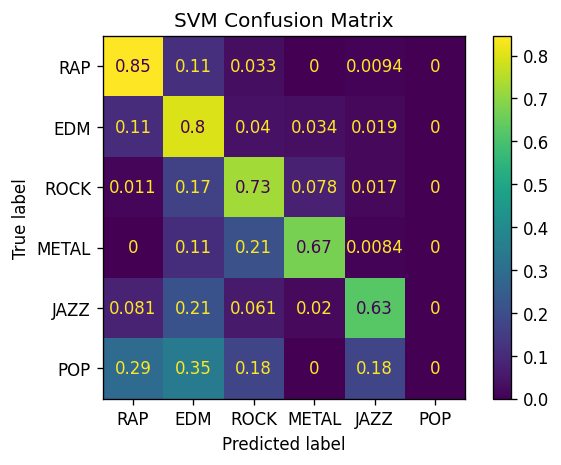

In [31]:
plot_confusion_matrix(clf, data_test, labels_test, display_labels=playlist_names, normalize='true')
plt.title('SVM Confusion Matrix')
plt.show()

From the above it is clear that the Pop playlists was not effective for classifying similar tracks. This is likely because of the overlap with other genres such as Rap and EDM where much of the confusion occured. Also not helping is that one of the sub-playlists is shared across EDM and Pop, electropop. as EDM is already such a larger playlist it is unsurpising that this performance was poor. Additionally the overlap with Rock is understandable as Pop contains an Indie Pop sub-playlist which could have cause some confusion. Quite surprising was the confusion for Jazz as I wouldn't have thought there would be much overlap here.

The other major confusion was with Rock and Metal, specifically classing Metal tracks as Rock. This could be expected due to the similarity in tone.

## Other Tests

Take a handful of other tracks which I don't listen to and aren't in any playlists to see if they can also be classified

In [32]:
### PREPARE ###
test_uris = ["spotify:track:53yqxU2EKKzbuQZEUEVtxc",
             "spotify:track:5W7xC99N2Zzfh69r7I7zWK",
             "spotify:track:38R2EViAkYOFG8ZkG3GLtW",
             "spotify:track:6T6D9CIrHkALcHPafDFA6L",
             "spotify:track:0sfdiwck2xr4PteGOdyOfz",
             "spotify:track:1BrgjqSg9du0lj3TUMLluL",
             "spotify:track:5nCnSnLtotQ8eB4E189U91",
             "spotify:track:3GOZbK2epuHzCt5YvvVFHO",
             "spotify:track:3cjF2OFRmip8spwZYQRKxP",
             "spotify:track:1COvXs6jaykXC73h9OSBVM"]
# inferring what playlists these would go in
test_labels = ["ROCK", "RAP", "JAZZ", "POP", "ROCK", "METAL", "METAL", "JAZZ", "RAP", "POP"] 

test_tracks = spotnet.tracks(uris=test_uris)
spotnet.populate_track_audio_features(tracks=test_tracks)

test_features = [   {j: k for j, k in i.audio_features.to_dict().items() 
                    if j in headers} 
                for i in test_tracks] # filter down to descriptor columns

### PREDICT ###
predictable_frame = pd.DataFrame(test_features)

predicted_labels = clf.predict(predictable_frame)
labels_correct = [i == playlist_names[predicted_labels[idx]] for idx, i in enumerate(test_labels)]

### EVALUATE ###
for track, label, correct in zip(test_tracks, predicted_labels, labels_correct):
    print(f'{track.name} ({track.artists[0].name}) could be {playlist_names[label]} {"✓" if correct else "✗"}')

correct = sum(labels_correct) / len(labels_correct)
print(f'\n{correct*100:.2f}% Accurate')

Top Of The World (Five Finger Death Punch) could be ROCK ✓
Aston Martin Music (Rick Ross) could be RAP ✓
On The Sunny Side Of The Street (Dizzy Gillespie) could be JAZZ ✓
Vibez (ZAYN) could be EDM ✗
Shot In The Dark (AC/DC) could be ROCK ✓
To Hell and Back (Sabaton) could be ROCK ✗
Withstand The Fall Of Time (Immortal) could be METAL ✓
Alone Together - Rudy Van Gelder Remaster (Kenny Dorham) could be JAZZ ✓
Feel No Ways (Drake) could be RAP ✓
BO$$ (Fifth Harmony) could be EDM ✗

70.00% Accurate


# Imports & Setup

In [20]:
from datetime import datetime

from google.cloud import bigquery
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

from analysis.net import get_spotnet, get_playlist, track_frame
from analysis.query import *
from analysis import spotify_descriptor_headers, float_headers, days_since

import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

client = bigquery.Client()
spotnet = get_spotnet()
cache = 'query.csv'
first_day = datetime(year=2017, month=11, day=3)

## Read Scrobble Frame

In [3]:
scrobbles = get_query(cache=cache)

## Write Scrobble Frame

In [6]:
scrobbles.reset_index().to_csv(cache, sep='\t')